# Calculation MGS
## This file shows how to use Mulguisin class

In [6]:
import mgs_class
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import collections
from time import time

### Read data file. The data is random data.

In [3]:
f = h5.File("rand_gal_data_210218_sig10.hdf5",'r')
x1 = np.array(f["x_rsd"])
y1 = np.array(f["y_rsd"])
z1 = np.array(f["z_rsd"])
f.close()
print('Length of data : ',len(x1))

Length of data :  5000


### MGS calculation
1. Parameters:  
Rcut : linking-length 
2. Return value:  
Nmgs : The number of MGS cluster/group  
imgs : Index of MGS. The total length is the same as data, but it is ordered by density  
clg : Galaxy id. 'clg' is list of list, there are galaxy ids in one cluster/group  
clm : Mother galaxy id  
cng : The number of member for each cluster/group  

In [4]:
Rcut = 10.0
MGS = mgs_class.mulguisin(Rcut,x1,y1,z1)
Nmgs, imgs, clg, clm, cng = MGS.get_mgs()

Calculate Voronoi density
Calculation is done. Time =  9.579765796661377
Calculate MGS
Calculation is done. Time =  1.8822662830352783


In [5]:
print('Total number of mgs : ', Nmgs)

Total number of mgs :  50


### Draw MGS cluster/group into 3D space

1. We make link information. It contains [mother_galaxy, children_galaxy, MGS_index]

In [11]:
links = np.zeros((1,3))
for i in range(Nmgs):
	for j in range(cng[i]):
		id_mom = clm[i][j]
		id_chi = clg[i][j]
		links = np.append(links,[[id_mom,id_chi,i]],axis=0)
links = np.delete(links,0,0)

2. We make label. The label indicates that the MGS index for each data point

In [12]:
label_mgs=np.full(len(x1),-1)
for i in range(Nmgs):
    tmp=links[np.where(links[:,2]==i),0:2]
    tmp=tmp.ravel()
    tmp=np.unique(tmp)
    for j in range(len(tmp)):
        itmp=int(tmp[j])
        label_mgs[itmp]=i

3. Finally, we make 3D distribution of MGS cluster/group

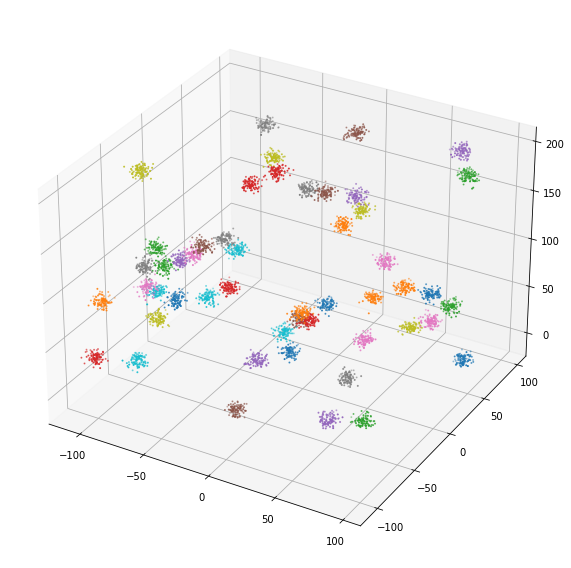

In [18]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection='3d')
for i in range(Nmgs):
    ind = np.where(label_mgs==i)[0]
    ax.scatter(x1[ind],y1[ind],z1[ind],s=1)
fig.tight_layout()

### Topological informations  
Now, we calculate topological informations.  
1. Total length : The sum of all distance of links in one cluster/group
2. Generation : The number of node from origin galaxy to each galaxy  
3. Length : The total length of one generation  
4. Number of children : The number of children for each galaxy  
5. Number of Degree : The number of node connected with other galaxy  
6. Number of branch : The number of branch for one cluster/group  
7. Opening angle : The angle made by three galaxies  
8. Polar angle : The angle based on observer (0,0,0)  
9. Polar angle from origin : The angle with observer and origin galaxy and other galaxy  

In [7]:
sta = time()
Totlength = []
for i in range(Nmgs):
    Totlength.append(MGS.Get_TotLength(i))

Generations = []
for i in range(Nmgs):
	for j in range(cng[i]):
		Generations.append(MGS.Get_generation(i,j))

Length = []
for i in range(Nmgs):
	for j in range(cng[i]):
		Length.append(MGS.Get_Length(i,j))

nChild = []
for i in range(Nmgs):
	for j in range(cng[i]):
		nChild.append(MGS.Get_Child(i,j))

nDegree = []
for i in range(Nmgs):
	for j in range(cng[i]):
		nDegree.append(MGS.Get_Degree(i,j))

nBranch = []
for i in range(Nmgs):
	nBranch.append(MGS.Get_Branch(i))

OpenAngle = []
for i in range(Nmgs):
	for j in range(cng[i]):
		openangle = MGS.Get_OpenAngle(i,j)
		OpenAngle.append(openangle)

PolarAngle = []
for i in range(Nmgs):
	for j in range(cng[i]):
		PolarAngle.append(MGS.Get_LinkPloarAngle(i,j))

end = time()
print('Time for calculating topological information = ', end - sta)

Time for calculating topological information =  10.464141845703125


If we cannot calculate opening angle or polar angle, we make code returning -1

In [9]:
OpenAngle = np.asarray(OpenAngle)
PolarAngle = np.asarray(PolarAngle)
mask_open = np.where(OpenAngle>=0)
mask_polar = np.where(PolarAngle>=0)

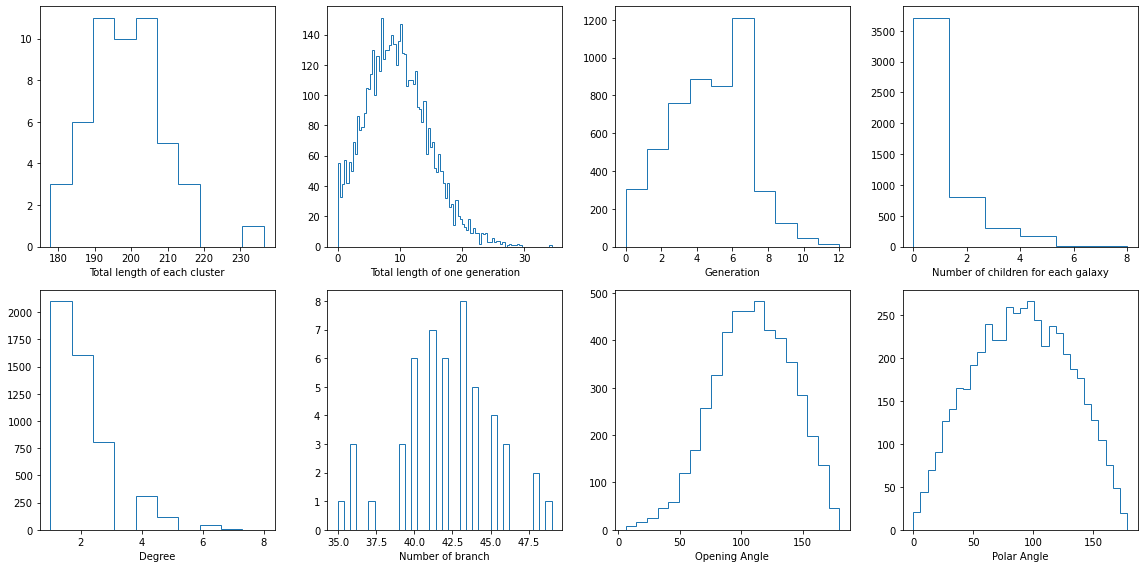

In [10]:
fig, ax = plt.subplots(2,4,figsize=(16,8))
ax[0,0].hist(Totlength,histtype='step')
ax[0,0].set_xlabel('Total length of each cluster')
ax[0,1].hist(Length,bins=100,histtype='step')
ax[0,1].set_xlabel('Total length of one generation')
ax[0,2].hist(Generations,histtype='step')
ax[0,2].set_xlabel('Generation')
ax[0,3].hist(nChild,bins=6,histtype='step')
ax[0,3].set_xlabel('Number of children for each galaxy')
ax[1,0].hist(nDegree,histtype='step')
ax[1,0].set_xlabel('Degree')
ax[1,1].hist(nBranch,bins=35,histtype='step')
ax[1,1].set_xlabel('Number of branch')
ax[1,2].hist(OpenAngle[mask_open]*(180./np.pi),bins=20,histtype='step')
ax[1,2].set_xlabel('Opening Angle')
ax[1,3].hist(PolarAngle[mask_polar]*(180./np.pi),bins=30,histtype='step')
ax[1,3].set_xlabel('Polar Angle')

plt.tight_layout()